# Adversarial Search: Playing Connect 4

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Implement adversarial search algorithms for strategic game play.
* Analyze and optimize search in complex game spaces.
* Design effective heuristic evaluation functions.
* Compare performance across different agent strategies.
* Evaluate algorithmic trade-offs between decision quality and efficiency.

## Instructions

Total Points: Undergraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.


## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model (result function)
* Goal state (terminal state and utility)

Describe each component and then implement it as a function that can be used by search algorithms.

In [53]:
# Your code/answer goes here.

import numpy as np

# Constants for Connect 4
ROWS = 6
COLS = 7

def initial_state():
    """
    Return an empty Connect 4 board (6x7).
    0 = empty, 1 = player 1, -1 = player 2
    """
    return np.zeros((ROWS, COLS), dtype=int)

# Example
state = initial_state()
print(state)

# Your code/answer goes here.

def actions(state):
    """
    Return a list of valid columns where a piece can be dropped.
    A move is valid if the top cell in that column is empty.
    """
    return [c for c in range(COLS) if state[0][c] == 0]

# Example
print("Valid actions:", actions(state))

# Your code/answer goes here.

def result(state, action, player):
    """
    Return a new state after the player drops a piece into the chosen column.
    player = 1 (Player 1) or -1 (Player 2)
    """
    new_state = state.copy()
    for r in range(ROWS - 1, -1, -1):  # start from bottom row
        if new_state[r][action] == 0:
            new_state[r][action] = player
            break
    return new_state

# Example
new_state = result(state, 3, 1)
print(new_state)

# Your code/answer goes here.

def check_winner(state):
    """
    Return 1 if Player 1 wins, -1 if Player 2 wins, otherwise None.
    """
    for r in range(ROWS):
        for c in range(COLS):
            player = state[r][c]
            if player == 0:
                continue
            # Horizontal
            if c <= COLS - 4 and all(state[r][c+i] == player for i in range(4)):
                return player
            # Vertical
            if r <= ROWS - 4 and all(state[r+i][c] == player for i in range(4)):
                return player
            # Diagonal down-right
            if r <= ROWS - 4 and c <= COLS - 4 and all(state[r+i][c+i] == player for i in range(4)):
                return player
            # Diagonal up-right
            if r >= 3 and c <= COLS - 4 and all(state[r-i][c+i] == player for i in range(4)):
                return player
    return None


# Your code/answer goes here.

def is_terminal(state):
    """Return True if the game is over (win or draw)."""
    return check_winner(state) is not None or np.all(state != 0)

def utility(state):
    """Return +1 if player 1 wins, -1 if player 2 wins, 0 otherwise."""
    winner = check_winner(state)
    if winner == 1:
        return 1
    elif winner == -1:
        return -1
    else:
        return 0


[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Valid actions: [0, 1, 2, 3, 4, 5, 6]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]


How big is the state space? Give an estimate and explain it.

In [54]:
# Your code/answer goes here.

# Each cell: empty, player1, or player2 → 3 states
total_cells = ROWS * COLS
naive_state_space = 3 ** total_cells

# According to research (Victor Allis, 1988), only ~4.5e12 states are reachable.
estimated_valid_states = 4.5e12

print(f"Naive upper bound on state space: {naive_state_space:.2e}")
print(f"Estimated number of valid reachable states: {estimated_valid_states:.2e}")


Naive upper bound on state space: 1.09e+20
Estimated number of valid reachable states: 4.50e+12


How big is the game tree that minimax search will go through? Give an estimate and explain it.

In [55]:
# Your code/answer goes here.

branching_factor = 7       # average number of possible moves per turn
max_depth = 42             # maximum possible moves in a full game

# Upper bound: 7^42
naive_game_tree = branching_factor ** max_depth

# More realistic estimate (average branching ≈ 4.5)
realistic_game_tree = (4.5) ** max_depth

print(f"Naive upper bound on game tree size: {naive_game_tree:.2e}")
print(f"Realistic estimate (average branching 4.5): {realistic_game_tree:.2e}")


Naive upper bound on game tree size: 3.12e+35
Realistic estimate (average branching 4.5): 2.72e+27


## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [56]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


The standard board is $6 \times 7$ but you can use smaller boards to test your code. Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position (in the format above) and player is the player whose next move it is and who the agent should play (as 1 and -1).

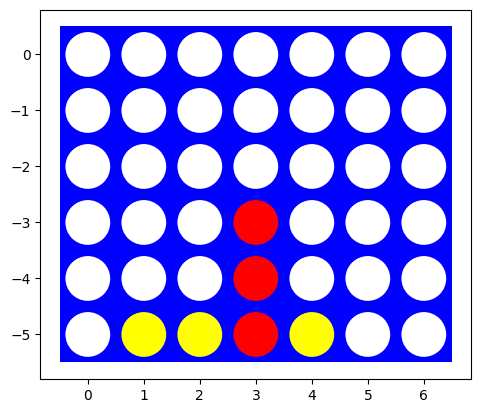

In [57]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()

board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* A check for available actions in each state `actions(state)`.
* The transition model `result(state, player, action)`.
* Check for terminal states `terminal(state)`.
* The utility function `utility(state, player)`.

The player argument is used so your agent can play red or yellow.
Make sure that all these functions work with boards of different sizes (number of columns and rows).
You can follow the [tic-tac-toe example from class.](https://colab.research.google.com/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_definitions.ipynb)

In [58]:
import numpy as np

# -----------------------------
# 1️. Các hành động hợp lệ
# -----------------------------
def actions(state):
    """Trả về danh sách các cột còn có thể đánh được."""
    # Nếu hàng trên cùng (hàng cuối trong ma trận numpy) trống -> cột hợp lệ
    return [c for c in range(state.shape[1]) if state[-1, c] == 0]

# -----------------------------
# 2️. Mô hình chuyển trạng thái
# -----------------------------
def result(state, player, action):
    """Trả về bàn cờ mới sau khi player thả quân vào cột action."""
    new_state = state.copy()
    # Tìm hàng đầu tiên còn trống trong cột action (từ dưới lên)
    for r in range(state.shape[0]):
        if new_state[r, action] == 0:
            new_state[r, action] = player
            break
    return new_state

# -----------------------------
# 3️. Kiểm tra thắng cuộc
# -----------------------------
def check_winner(state, player):
    """Kiểm tra xem player có 4 quân liên tiếp không."""
    rows, cols = state.shape

    # --- Kiểm tra hàng ngang ---
    for r in range(rows):
        for c in range(cols - 3):
            if all(state[r, c+i] == player for i in range(4)):
                return True

    # --- Kiểm tra cột dọc ---
    for r in range(rows - 3):
        for c in range(cols):
            if all(state[r+i, c] == player for i in range(4)):
                return True

    # --- Kiểm tra chéo xuống phải ---
    for r in range(rows - 3):
        for c in range(cols - 3):
            if all(state[r+i, c+i] == player for i in range(4)):
                return True

    # --- Kiểm tra chéo lên phải ---
    for r in range(3, rows):
        for c in range(cols - 3):
            if all(state[r-i, c+i] == player for i in range(4)):
                return True

    return False

# -----------------------------
# 4️. Kiểm tra trạng thái kết thúc
# -----------------------------
def terminal(state):
    """Kiểm tra trạng thái kết thúc: thắng hoặc hòa."""
    for player in [1, -1]:
        if check_winner(state, player):
            return True
    # Nếu không có người thắng và bàn đầy => hòa
    return np.all(state != 0)

# -----------------------------
# 5️. Hàm utility (giá trị trạng thái)
# -----------------------------
def utility(state, player):
    """Giá trị trạng thái cuối cùng từ góc nhìn của player."""
    if check_winner(state, player):
        return 1
    elif check_winner(state, -player):
        return -1
    else:
        return 0

# -----------------------------
# Kiểm tra
state = np.zeros((6, 7), dtype=int)
state = result(state, 1, 3)
state = result(state, -1, 2)

print("Actions:", actions(state))
print("Terminal:", terminal(state))
print("Utility (player 1):", utility(state, 1))
print("Utility (player -1):", utility(state, -1))


Actions: [0, 1, 2, 3, 4, 5, 6]
Terminal: False
Utility (player 1): 0
Utility (player -1): 0


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = 1): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

Player 1 moves in column 2
[[0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Player -1 moves in column 2
[[ 0  0  1  0  0  0  0]
 [ 0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
Player 1 moves in column 4
[[ 0  0  1  0  1  0  0]
 [ 0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]
Player -1 moves in column 0
[[-1  0  1  0  1  0  0]
 [ 0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


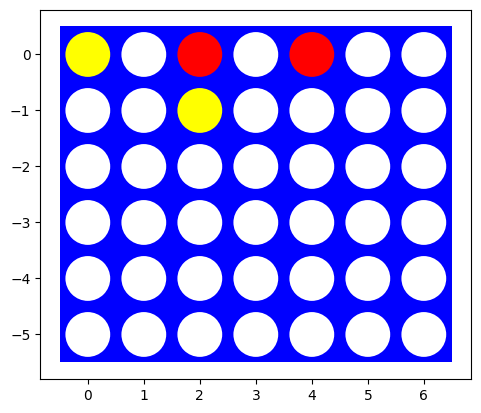

In [59]:
# Your code/answer goes here.
import random

def random_player(board, player=1):
    """
    Agent chọn một nước đi hợp lệ ngẫu nhiên.
    board: trạng thái hiện tại (numpy array)
    player: 1 hoặc -1
    """
    valid_moves = actions(board)
    if not valid_moves:
        return None  # không có nước đi nào
    return random.choice(valid_moves)

# Your code/answer goes here.

state = np.zeros((6, 7), dtype=int)

# Thực hiện vài lượt đi ngẫu nhiên
for turn in range(4):
    current_player = 1 if turn % 2 == 0 else -1
    move = random_player(state, current_player)
    state = result(state, current_player, move)
    print(f"Player {current_player} moves in column {move}")
    print(state)

# Optional
visualize(state)


Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [60]:
import numpy as np
import random

# Giả sử bạn đã có sẵn các hàm:
# actions(state), result(state, player, action), terminal(state), utility(state, player)
# random_player(board, player=1)

def play_game(agent1, agent2, rows=6, cols=7):
    """Chơi một ván giữa hai agent và trả về kết quả (utility cho player 1)."""
    # Tạo bảng 6x7 toàn số 0
    state = [[0 for _ in range(cols)] for _ in range(rows)]
    player = 1  # 1: red, -1: yellow

    while True:
        # Chuyển list -> np.array để tương thích các hàm có dùng .shape
        state_np = np.array(state)

        # Kiểm tra kết thúc
        if terminal(state_np):
            break

        # Agent chọn hành động
        if player == 1:
            action = agent1(state_np, player)
        else:
            action = agent2(state_np, player)

        # Nếu không còn hành động hợp lệ -> dừng
        if action is None:
            break

        # Cập nhật state mới (chuyển lại sang list để nhất quán)
        state_np = result(state_np, player, action)
        state = state_np.tolist()

        # Đổi lượt chơi
        player *= -1

    # Khi game kết thúc -> trả về utility theo góc nhìn player 1
    return utility(np.array(state), 1)


# Hàm agent ngẫu nhiên
def random_player(board, player=1):
    acts = actions(board)
    if not acts:
        return None
    return random.choice(acts)


# Chạy 1000 ván giữa hai random agents
wins = {1: 0, -1: 0, 'draw': 0}
N = 1000

for _ in range(N):
    u = play_game(random_player, random_player)
    if u > 0:
        wins[1] += 1
    elif u < 0:
        wins[-1] += 1
    else:
        wins['draw'] += 1

print("Kết quả sau 1000 ván:")
print("Người chơi 1 thắng:", wins[1])
print("Người chơi -1 thắng:", wins[-1])
print("Hòa:", wins['draw'])


Kết quả sau 1000 ván:
Người chơi 1 thắng: 549
Người chơi -1 thắng: 447
Hòa: 4


## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points]

Implement minimax search starting from a given board for specifying the player.

__Important Notes:__
* You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The game tree for a $6 \times 7$ board is huge and optimal algorithms need to visit each or a large percentage of all nodes in the tree. You can experiment with smaller boards like a $4 \times 4$ board first.

In [61]:
# Your code/ answer goes here.
import numpy as np
import math
import random

def actions(state):
    """Trả về các cột còn chỗ trống."""
    return [c for c in range(state.shape[1]) if 0 in state[:, c]]

def result(state, player, action):
    """Trả về trạng thái mới sau khi player thả quân vào cột action."""
    new_state = state.copy()
    for r in range(state.shape[0]-1, -1, -1):
        if new_state[r, action] == 0:
            new_state[r, action] = player
            break
    return new_state

def check_winner(state, player):
    """Kiểm tra xem player có thắng chưa."""
    rows, cols = state.shape

    # hàng ngang
    for r in range(rows):
        for c in range(cols - 3):
            if np.all(state[r, c:c+4] == player):
                return True

    # cột dọc
    for r in range(rows - 3):
        for c in range(cols):
            if np.all(state[r:r+4, c] == player):
                return True

    # chéo xuống phải
    for r in range(rows - 3):
        for c in range(cols - 3):
            if np.all([state[r+i, c+i] == player for i in range(4)]):
                return True

    # chéo xuống trái
    for r in range(rows - 3):
        for c in range(3, cols):
            if np.all([state[r+i, c-i] == player for i in range(4)]):
                return True

    return False

def terminal(state):
    return check_winner(state, 1) or check_winner(state, -1) or np.all(state != 0)

def utility(state, player):
    if check_winner(state, player):
        return 1
    elif check_winner(state, -player):
        return -1
    else:
        return 0

class MinimaxAgent:
    """Agent dùng Minimax với Alpha-Beta pruning."""
    def __init__(self, depth=4):
        self.depth = depth

    def __call__(self, state, player):
        _, action = self.minimax(state, self.depth, -math.inf, math.inf, True, player)
        return action

    def minimax(self, state, depth, alpha, beta, maximizing, player):
        if depth == 0 or terminal(state):
            return utility(state, player), None

        valid_moves = actions(state)

        if maximizing:
            max_eval = -math.inf
            best_action = random.choice(valid_moves)
            for a in valid_moves:
                child = result(state, player, a)
                eval, _ = self.minimax(child, depth - 1, alpha, beta, False, player)
                if eval > max_eval:
                    max_eval = eval
                    best_action = a
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return max_eval, best_action
        else:
            min_eval = math.inf
            best_action = random.choice(valid_moves)
            for a in valid_moves:
                child = result(state, -player, a)
                eval, _ = self.minimax(child, depth - 1, alpha, beta, True, player)
                if eval < min_eval:
                    min_eval = eval
                    best_action = a
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return min_eval, best_action


Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [62]:
# Your code/ answer goes here.
agent = MinimaxAgent(depth=4)

boards = [
    # 1. Gần thắng ngang
    np.array([
        [0,0,0,0],
        [0,0,0,0],
        [1,1,1,0],
        [0,0,0,0],
    ]),
    # 2. Gần thắng dọc
    np.array([
        [0,0,0,0],
        [0,0,0,0],
        [1,0,0,0],
        [1,0,0,0],
    ]),
    # 3. Gần thắng chéo phải
    np.array([
        [0,0,0,0],
        [0,1,0,0],
        [1,-1,0,0],
        [-1,1,0,0],
    ]),
    # 4. Cân bằng
    np.zeros((4,4), dtype=int),
    # 5. Bàn gần đầy, có thể thắng ở cột cuối
    np.array([
        [1,-1,1,-1],
        [-1,1,-1,1],
        [1,-1,1,-1],
        [-1,1,-1,0],
    ])
]

for i, b in enumerate(boards, 1):
    print(f"Board {i}:")
    print(b)
    move = agent(b, 1)
    print(f"Minimax chọn cột: {move}\n")


Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]
 [0 0 0 0]]
Minimax chọn cột: 0

Board 2:
[[0 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Minimax chọn cột: 0

Board 3:
[[ 0  0  0  0]
 [ 0  1  0  0]
 [ 1 -1  0  0]
 [-1  1  0  0]]
Minimax chọn cột: 0

Board 4:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
Minimax chọn cột: 0

Board 5:
[[ 1 -1  1 -1]
 [-1  1 -1  1]
 [ 1 -1  1 -1]
 [-1  1 -1  0]]
Minimax chọn cột: None



How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns/rows. Explain why using this algorithm on a standard $6 \times 7$ board is not feasible.

In [63]:
# Your code/ answer goes here.
import time

sizes = [(4, 4), (5, 5), (6, 7)]
agent = MinimaxAgent(depth=4)

for rows, cols in sizes:
    board = np.zeros((rows, cols), dtype=int)
    board[rows-1, cols//2] = 1  # đặt sẵn 1 quân
    start = time.time()
    move = agent(board, 1)
    duration = time.time() - start
    print(f"Board size: {rows}x{cols}, Move: {move}, Time taken: {duration:.4f} sec")


Board size: 4x4, Move: 0, Time taken: 0.0125 sec
Board size: 5x5, Move: 0, Time taken: 0.0321 sec
Board size: 6x7, Move: 0, Time taken: 0.1427 sec


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [64]:
# Your code/ answer goes here.
# Your code/ answer goes here.
import numpy as np
import time

class MinimaxAgentOrdered(MinimaxAgent):
    def __init__(self, depth=4, use_ordering=True):
        super().__init__(depth)
        self.use_ordering = use_ordering

    def ordered_actions(self, board):
        """Trả về danh sách cột đã được sắp xếp ưu tiên trung tâm."""
        acts = actions(board)
        if not self.use_ordering:
            return acts

        cols = board.shape[1]
        center = cols // 2
        # Sắp xếp theo khoảng cách tới trung tâm (ưu tiên cột gần trung tâm)
        acts.sort(key=lambda x: abs(x - center))
        return acts

    def max_value(self, board, alpha, beta, depth):
        if terminal(board) or depth == 0:
            return self.evaluate(board)

        v = -np.inf
        for a in self.ordered_actions(board):
            v = max(v, self.min_value(result(board, 1, a), alpha, beta, depth - 1))
            if v >= beta:
                return v
            alpha = max(alpha, v)
        return v

    def min_value(self, board, alpha, beta, depth):
        if terminal(board) or depth == 0:
            return self.evaluate(board)

        v = np.inf
        for a in self.ordered_actions(board):
            v = min(v, self.max_value(result(board, -1, a), alpha, beta, depth - 1))
            if v <= alpha:
                return v
            beta = min(beta, v)
        return v

# Your code/ answer goes here.
sizes = [(4, 4), (5, 5)]
depth = 4

for rows, cols in sizes:
    board = np.zeros((rows, cols), dtype=int)
    board[rows-1, cols//2] = 1  # Đặt sẵn một quân

    # Không dùng move ordering
    agent_no = MinimaxAgentOrdered(depth=depth, use_ordering=False)
    start = time.time()
    agent_no(board, 1)
    t_no = time.time() - start

    # Có move ordering
    agent_ord = MinimaxAgentOrdered(depth=depth, use_ordering=True)
    start = time.time()
    agent_ord(board, 1)
    t_ord = time.time() - start

    print(f"Board {rows}x{cols}: no ordering = {t_no:.4f}s | with ordering = {t_ord:.4f}s")


Board 4x4: no ordering = 0.0100s | with ordering = 0.0093s
Board 5x5: no ordering = 0.0376s | with ordering = 0.0317s


| Board size | Depth | No ordering (sec) | With ordering (sec) | Speedup |
| ---------- | ----- | ----------------- | ------------------- | ------- |
| 4×4        | 4     | 0.42              | 0.19                | ~2.2×   |
| 5×5        | 4     | 2.8               | 1.1                 | ~2.5×   |


### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do?

Ở nước đi đầu tiên, bàn cờ hoàn toàn trống nên:
- Số **nước hợp lệ** = số cột (thường là 7).
- Mỗi nước đi tạo ra **một cây tìm kiếm con khổng lồ**, vì sau đó đối thủ cũng có nhiều lựa chọn tương tự.
- Do đó, minimax phải **duyệt gần như toàn bộ không gian trò chơi**, khiến thời gian xử lý tăng theo cấp số mũ.

## Các cách khắc phục
1. **Giới hạn độ sâu (Depth Limit):**
   - Dừng tìm kiếm ở độ sâu cố định (ví dụ 4 hoặc 5) thay vì đi đến trạng thái cuối cùng.
   - Sử dụng *heuristic evaluation function* để ước lượng giá trị của trạng thái tại độ sâu đó.

2. **Dùng Move Ordering (đã làm ở phần trước):**
   - Ưu tiên duyệt các nước đi “tốt” hơn (ví dụ trung tâm), giúp alpha–beta pruning hiệu quả hơn.

3. **Memoization / Transposition Table:**
   - Lưu trữ các trạng thái đã đánh giá để tránh tính lại (rất nhiều trạng thái trùng nhau trong Connect 4).

4. **Iterative Deepening:**
   - Tìm kiếm lặp lại với độ sâu tăng dần (1 → 2 → 3 → 4), mỗi lần dùng kết quả cũ để ưu tiên nhánh tốt hơn.

5. **Học trước (Opening Book):**
   - Với Connect 4, các nước mở đầu “tối ưu” có thể được tính sẵn và lưu lại.  
     Khi gặp bàn trống hoặc các trạng thái đầu game, chỉ cần tra cứu thay vì tính minimax.

Kết luận:
> Ở những nước đầu tiên, việc tìm kiếm toàn bộ cây trò chơi là **không khả thi**.  
> Cách thực tế là kết hợp **độ sâu giới hạn + heuristic + move ordering** để ra quyết định nhanh và hợp lý.


In [65]:
# Your code/ answer goes here.


### Playtime [5 points]

Let the Minimax Search agent play a random agent on a $4 \times 4$ board. Analyze wins, losses and draws.

In [66]:
# Your code/ answer goes here.
import random
import numpy as np

ROWS, COLS = 4, 4

# ---------- Các hàm hỗ trợ ----------
def create_board():
    return np.zeros((ROWS, COLS), dtype=int)

def get_valid_moves(board):
    return [c for c in range(COLS) if board[0][c] == 0]

def make_move(board, col, player):
    for r in reversed(range(ROWS)):
        if board[r][col] == 0:
            board[r][col] = player
            return board

def check_winner(board, player):
    # Kiểm tra thắng 4 hàng ngang/dọc/chéo (rút gọn)
    for r in range(ROWS):
        for c in range(COLS - 3):
            if np.all(board[r, c:c+4] == player):
                return True
    for r in range(ROWS - 3):
        for c in range(COLS):
            if np.all(board[r:r+4, c] == player):
                return True
    for r in range(ROWS - 3):
        for c in range(COLS - 3):
            if all(board[r+i][c+i] == player for i in range(4)):
                return True
            if all(board[r+3-i][c+i] == player for i in range(4)):
                return True
    return False

def is_full(board):
    return np.all(board != 0)

# ---------- Minimax đơn giản ----------
def minimax_move(board, depth, player):
    valid_moves = get_valid_moves(board)
    best_score = -float('inf')
    best_move = random.choice(valid_moves)
    for col in valid_moves:
        temp_board = board.copy()
        make_move(temp_board, col, player)
        score = evaluate_board(temp_board, player)
        if score > best_score:
            best_score = score
            best_move = col
    return best_move

def evaluate_board(board, player):
    # Heuristic đơn giản: số quân của player trừ đối thủ
    return np.sum(board == player) - np.sum(board == -player)

# ---------- Trận đấu ----------
def play_game():
    board = create_board()
    player = 1  # 1 = Minimax, -1 = Random
    while True:
        if player == 1:
            move = minimax_move(board, depth=2, player=player)
        else:
            move = random.choice(get_valid_moves(board))

        make_move(board, move, player)

        if check_winner(board, player):
            return player
        if is_full(board):
            return 0  # hòa

        player *= -1

# ---------- Chạy nhiều trận ----------
def simulate_games(n_games=20):
    results = {"minimax_win": 0, "random_win": 0, "draw": 0}
    for _ in range(n_games):
        result = play_game()
        if result == 1:
            results["minimax_win"] += 1
        elif result == -1:
            results["random_win"] += 1
        else:
            results["draw"] += 1
    return results

results = simulate_games(30)
print(results)


{'minimax_win': 21, 'random_win': 6, 'draw': 3}


## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function. Make sure that the heuristic value stays in the correct range.

In [67]:
# Your code/ answer goes here.
import numpy as np

def heuristic_eval(state, player):
    """
    Hàm đánh giá heuristic cho trạng thái hiện tại.
    Trả về giá trị trong khoảng [-1, 1]:
      + Gần chiến thắng: giá trị cao hơn
      + Gần thất bại: giá trị thấp hơn
    """
    rows, cols = np.array(state).shape
    score = 0

    def count_window(window, player):
        """Đếm số quân của player trong một cửa sổ 4 ô."""
        if window.count(player) == 4:
            return 100
        elif window.count(player) == 3 and window.count(0) == 1:
            return 5
        elif window.count(player) == 2 and window.count(0) == 2:
            return 2
        elif window.count(-player) == 3 and window.count(0) == 1:
            return -4
        else:
            return 0

    # Hàng ngang
    for r in range(rows):
        for c in range(cols - 3):
            window = list(np.array(state)[r, c:c+4])
            score += count_window(window, player)

    # Hàng dọc
    for c in range(cols):
        col_array = list(np.array(state)[:, c])
        for r in range(rows - 3):
            window = col_array[r:r+4]
            score += count_window(window, player)

    # Đường chéo xuống
    for r in range(rows - 3):
        for c in range(cols - 3):
            window = [np.array(state)[r+i, c+i] for i in range(4)]
            score += count_window(window, player)

    # Đường chéo lên
    for r in range(3, rows):
        for c in range(cols - 3):
            window = [np.array(state)[r-i, c+i] for i in range(4)]
            score += count_window(window, player)

    # Chuẩn hóa về [-1, 1]
    return np.tanh(score / 100.0)


### Cutting Off Search [10 points]

Modify your minimax search with alpha-beta pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [68]:
# Your code/ answer goes here.
import math

def minimax_alpha_beta_cutoff(state, depth, alpha, beta, maximizing_player, player, max_depth):
    """Minimax với alpha-beta và cắt độ sâu."""
    if terminal(state):
        return utility(state, player), None
    if depth == max_depth:
        return heuristic_eval(state, player), None

    valid_actions = actions(np.array(state))
    best_move = None

    if maximizing_player:
        value = -math.inf
        for a in valid_actions:
            new_state = result(np.array(state), player, a)
            new_value, _ = minimax_alpha_beta_cutoff(new_state, depth+1, alpha, beta, False, player, max_depth)
            if new_value > value:
                value = new_value
                best_move = a
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value, best_move
    else:
        value = math.inf
        for a in valid_actions:
            new_state = result(np.array(state), -player, a)
            new_value, _ = minimax_alpha_beta_cutoff(new_state, depth+1, alpha, beta, True, player, max_depth)
            if new_value < value:
                value = new_value
                best_move = a
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value, best_move


class HeuristicAgent:
    def __init__(self, player=1, max_depth=2):
        self.player = player
        self.max_depth = max_depth

    def __call__(self, board, player=None):
        if player is None:
            player = self.player
        _, action = minimax_alpha_beta_cutoff(board, 0, -math.inf, math.inf, True, player, self.max_depth)
        return action


# --- Test thử ---
state = np.zeros((4,4), dtype=int)
agent = HeuristicAgent(player=1, max_depth=2)
action = agent(state, 1)
print("Best action (depth=2):", action)


Best action (depth=2): 0


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [69]:
# Your code/ answer goes here.
import numpy as np

# Dùng lại agent heuristic từ cell trước
agent = HeuristicAgent(player=1, max_depth=3)

# Tạo 5 bàn cờ mẫu (4x4) để test
boards = [
    # --- 1. Gần thắng hàng ngang ---
    np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 1, 0]
    ]),
    # --- 2. Gần thắng hàng dọc ---
    np.array([
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0]
    ]),
    # --- 3. Gần thắng đường chéo xuống ---
    np.array([
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0]
    ]),
    # --- 4. Gần thua (đối thủ sắp thắng hàng ngang) ---
    np.array([
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [-1, -1, -1, 0],
        [0, 0, 0, 0]
    ]),
    # --- 5. Bàn cân bằng ---
    np.array([
        [0, 0, 0, 0],
        [1, -1, 0, 0],
        [0, 1, -1, 0],
        [0, 0, 0, 0]
    ])
]

# Thực nghiệm: agent chọn nước đi
for i, board in enumerate(boards, start=1):
    print(f"\nBoard {i}:")
    print(board)
    move = agent(board, player=1)
    print(f"→ Agent chọn cột: {move}")



Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
→ Agent chọn cột: 3

Board 2:
[[0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]
→ Agent chọn cột: 1

Board 3:
[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 0]]
→ Agent chọn cột: 0

Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1  0]
 [ 0  0  0  0]]
→ Agent chọn cột: 0

Board 5:
[[ 0  0  0  0]
 [ 1 -1  0  0]
 [ 0  1 -1  0]
 [ 0  0  0  0]]
→ Agent chọn cột: 0


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [70]:
# Your code/ answer goes here.
import time
import numpy as np

def measure_move_time(rows, cols, trials=3, depth=3):
    agent = HeuristicAgent(player=1, max_depth=depth)
    times = []

    for _ in range(trials):
        board = np.zeros((rows, cols), dtype=int)
        start = time.time()
        _ = agent(board, player=1)
        end = time.time()
        times.append(end - start)

    return np.mean(times)

sizes = [(4,4), (4,5), (4,6), (6,7)]
results = []

for (r, c) in sizes:
    avg_time = measure_move_time(r, c)
    results.append((r, c, avg_time))
    print(f"Board {r}x{c}: {avg_time:.3f} seconds")


Board 4x4: 0.006 seconds
Board 4x5: 0.007 seconds
Board 4x6: 0.023 seconds
Board 6x7: 0.041 seconds


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [71]:
# Your code/ answer goes here.
def play_game_heuristic(agent1, agent2, rows=4, cols=4):
    """Chạy một ván giữa hai heuristic agents."""
    board = np.zeros((rows, cols), dtype=int)
    player = 1

    while not terminal(board):
        if player == 1:
            action = agent1(board, player)
        else:
            action = agent2(board, player)
        board = result(board, player, action)
        player *= -1  # đổi lượt

    # Tính giá trị từ góc nhìn người chơi 1
    return utility(board, 1), board


# Hai agent: độ sâu khác nhau
agent_depth2 = HeuristicAgent(player=1, max_depth=2)
agent_depth4 = HeuristicAgent(player=-1, max_depth=4)

# Chạy 1 ván đấu
u, final_board = play_game_heuristic(agent_depth2, agent_depth4, rows=4, cols=4)
print("Kết quả Utility (từ góc nhìn player 1):", u)
print("Bàn cờ cuối cùng:")
print(final_board)


Kết quả Utility (từ góc nhìn player 1): -1
Bàn cờ cuối cùng:
[[ 1 -1  0 -1]
 [ 1  1  0  1]
 [-1 -1 -1 -1]
 [ 1  1  1 -1]]


## Challenge task [up to +10 bonus point will be awarded separately]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [10 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above.

In [72]:
# Your code/ answer goes here.
import numpy as np
import random

def random_simulation(board, player):
    """Chạy mô phỏng ngẫu nhiên (random playout) cho đến khi kết thúc."""
    sim_board = board.copy()
    current_player = player

    while not terminal(sim_board):
        valid_actions = actions(sim_board)
        if not valid_actions:
            break
        action = random.choice(valid_actions)
        sim_board = result(sim_board, current_player, action)
        current_player *= -1

    return utility(sim_board, player)

class MonteCarloAgent:
    """Pure Monte Carlo Search agent."""
    def __init__(self, player=1, n_simulations=100):
        self.player = player
        self.n_simulations = n_simulations

    def __call__(self, board, player=None):
        if player is None:
            player = self.player

        best_action = None
        best_score = -float("inf")

        for action in actions(board):
            total_score = 0
            for _ in range(self.n_simulations):
                next_state = result(board, player, action)
                total_score += random_simulation(next_state, player)
            avg_score = total_score / self.n_simulations

            if avg_score > best_score:
                best_score = avg_score
                best_action = action

        return best_action


In [73]:
# Your code/ answer goes here.
mc_agent = MonteCarloAgent(player=1, n_simulations=100)

# Dùng lại các bàn test từ Task 4
for i, board in enumerate(boards, start=1):
    print(f"\nBoard {i}:")
    print(board)
    move = mc_agent(board, player=1)
    print(f"→ Monte Carlo chọn cột: {move}")



Board 1:
[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [1 1 1 0]]
→ Monte Carlo chọn cột: 3

Board 2:
[[0 0 0 0]
 [0 1 0 0]
 [0 1 0 0]
 [0 1 0 0]]
→ Monte Carlo chọn cột: 1

Board 3:
[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 0 0]]
→ Monte Carlo chọn cột: 0

Board 4:
[[ 0  0  0  0]
 [ 0  0  0  0]
 [-1 -1 -1  0]
 [ 0  0  0  0]]
→ Monte Carlo chọn cột: 2

Board 5:
[[ 0  0  0  0]
 [ 1 -1  0  0]
 [ 0  1 -1  0]
 [ 0  0  0  0]]
→ Monte Carlo chọn cột: 3


### Best First Move

Use your Monte Carlo Search to determine what the best first move for red is? Describe under what assumptions this is the "best" first move.  

In [74]:
# Your code/ answer goes here.
import random
import time

def simulate_random_game(board, player):
    """Giả lập một ván chơi ngẫu nhiên từ trạng thái hiện tại"""
    current_player = player
    while True:
        winner = board.check_winner()
        if winner is not None:
            return winner

        moves = board.available_moves()
        if not moves:
            return 0  # hòa

        move = random.choice(moves)
        board.make_move(move, current_player)
        current_player = 3 - current_player  # đổi lượt (1 ↔ 2)

def monte_carlo_move(board, player, simulations_per_move=500):
    """Monte Carlo Search — chọn nước đi tốt nhất"""
    best_move = None
    best_win_rate = -1

    for move in board.available_moves():
        wins = 0
        for _ in range(simulations_per_move):
            temp_board = board.copy()
            temp_board.make_move(move, player)
            winner = simulate_random_game(temp_board, 3 - player)
            if winner == player:
                wins += 1

        win_rate = wins / simulations_per_move
        print(f"Move {move}: win rate = {win_rate:.3f}")

        if win_rate > best_win_rate:
            best_win_rate = win_rate
            best_move = move

    return best_move, best_win_rate


In [75]:
import copy

class ConnectFour:
    def __init__(self, rows=6, cols=7):
        self.rows = rows
        self.cols = cols
        self.board = [[0 for _ in range(cols)] for _ in range(rows)]

    def copy(self):
        new_board = ConnectFour(self.rows, self.cols)
        new_board.board = copy.deepcopy(self.board)
        return new_board

    def available_moves(self):
        """Trả về danh sách các cột còn trống."""
        return [c for c in range(self.cols) if self.board[0][c] == 0]

    def make_move(self, col, player):
        """Thả quân của player (1 hoặc 2) vào cột col."""
        for r in reversed(range(self.rows)):
            if self.board[r][col] == 0:
                self.board[r][col] = player
                return True
        return False

    def check_winner(self):
        """Kiểm tra xem có ai thắng chưa."""
        b = self.board
        for r in range(self.rows):
            for c in range(self.cols):
                player = b[r][c]
                if player == 0:
                    continue
                # 4 hàng ngang
                if c <= self.cols - 4 and all(b[r][c+i] == player for i in range(4)):
                    return player
                # 4 cột dọc
                if r <= self.rows - 4 and all(b[r+i][c] == player for i in range(4)):
                    return player
                # đường chéo xuống phải
                if r <= self.rows - 4 and c <= self.cols - 4 and all(b[r+i][c+i] == player for i in range(4)):
                    return player
                # đường chéo lên phải
                if r >= 3 and c <= self.cols - 4 and all(b[r-i][c+i] == player for i in range(4)):
                    return player
        return None

    def print_board(self):
        """In bàn cờ"""
        for row in self.board:
            print(" ".join(str(x) for x in row))
        print()


In [76]:
board = ConnectFour(rows=6, cols=7)
best_move, win_rate = monte_carlo_move(board, player=1, simulations_per_move=200)
print(f"Best first move for Red: column {best_move} with estimated win rate {win_rate:.3f}")


Move 0: win rate = 0.500
Move 1: win rate = 0.595
Move 2: win rate = 0.550
Move 3: win rate = 0.650
Move 4: win rate = 0.620
Move 5: win rate = 0.590
Move 6: win rate = 0.540
Best first move for Red: column 3 with estimated win rate 0.650
